# Experiment 6: XGBoost + Fair-SMOTE (Class Imbalance Mitigation) - Retrain + Validate

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Step 0: Setup Environment
!pip install imbalanced-learn shap xgboost aif360 scikit-learn pandas matplotlib seaborn joblib openpyxl --quiet


In [14]:
# Step 1: Imports
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt   # <-- add this line
from imblearn.over_sampling import SMOTE

from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric


In [15]:
# Step 2: Load and Preprocess Training Dataset
df = pd.read_csv('/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv')

selected_cols = ['loan_status', 'annual_inc', 'term', 'grade', 'home_ownership', 'purpose', 'zip_code']
df = df[selected_cols].dropna()

df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)

for col in ['term', 'grade', 'home_ownership', 'purpose', 'zip_code']:
    df[col] = LabelEncoder().fit_transform(df[col])

df['annual_inc'] = StandardScaler().fit_transform(df[['annual_inc']])

In [16]:
# Step 3: Create AIF360 Dataset
privileged_groups = [{'zip_code': 1}]
unprivileged_groups = [{'zip_code': 0}]

aif_data = StandardDataset(df,
                           label_name='loan_status',
                           favorable_classes=[1],
                           protected_attribute_names=['zip_code'],
                           privileged_classes=[[1]])

In [17]:
# Step 4: Apply Fair-SMOTE
X = aif_data.features
y = aif_data.labels.ravel()

sm = SMOTE(random_state=42)
X_balanced, y_balanced = sm.fit_resample(X, y)

In [18]:
# Step 5: Train XGBoost
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
clf.fit(X_balanced, y_balanced)

# Save model
MODEL_PATH = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/trained models/xgb_fairsmote_v2.pkl'
joblib.dump(clf, MODEL_PATH)
print(f'Model retrained and saved to: {MODEL_PATH}')

Model retrained and saved to: /content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/trained models/xgb_fairsmote_v2.pkl


In [19]:
# Step 6: Preprocess Test Dataset
def preprocess_testdata(df):
    df = df.copy()
    processed = pd.DataFrame()

    scaler = StandardScaler()
    processed['annual_inc'] = scaler.fit_transform(df[['annual_inc']].fillna(df['annual_inc'].median())).ravel()

    le = LabelEncoder()
    processed['term'] = le.fit_transform(df['term'].astype(str))

    le = LabelEncoder()
    processed['grade'] = le.fit_transform(df['grade'].astype(str))

    le = LabelEncoder()
    processed['home_ownership'] = le.fit_transform(df['home_ownership'].astype(str))

    le = LabelEncoder()
    processed['purpose'] = le.fit_transform(df['purpose'].astype(str))

    le = LabelEncoder()
    processed['zip_code'] = le.fit_transform(df['zip_code'].astype(str))

    status_map = {
        'Fully Paid': 1,
        'Current': 1,
        'Charged Off': 0,
        'Default': 0,
        'Late (31-120 days)': 0,
        'Late (16-30 days)': 0,
        'In Grace Period': 0
    }
    df['loan_status_mapped'] = df['loan_status'].map(status_map).fillna(0).astype(int)
    processed['loan_status'] = df['loan_status_mapped']

    return processed.dropna()

In [20]:
# Step 7: Validation Function
def validate_on_testdata(df_processed, model):
    privileged_groups = [{'zip_code': 1}]
    unprivileged_groups = [{'zip_code': 0}]

    aif_data = StandardDataset(df_processed,
                               label_name='loan_status',
                               favorable_classes=[1],
                               protected_attribute_names=['zip_code'],
                               privileged_classes=[[1]])
    X = aif_data.features
    y = aif_data.labels.ravel()
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]

    print('\nPERFORMANCE METRICS')
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Precision:", precision_score(y, y_pred))
    print("Recall:", recall_score(y, y_pred))
    print("F1 Score:", f1_score(y, y_pred))
    print("AUC-ROC:", roc_auc_score(y, y_prob))

    print('\nClassification Report:')
    print(classification_report(y, y_pred, zero_division=0))

    print('\nFAIRNESS METRICS')
    pred_dataset = aif_data.copy()
    pred_dataset.labels = y_pred.reshape(-1, 1)
    metric = ClassificationMetric(aif_data, pred_dataset,
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups)
    print("SPD:", metric.statistical_parity_difference())
    print("DI:", metric.disparate_impact())
    print("EOD:", metric.equal_opportunity_difference())
    print("AOD:", metric.average_odds_difference())
    print("Bias Amplification:", metric.between_group_generalized_entropy_index())
    print("Theil Index:", metric.theil_index())

    print('\nEXPLAINABILITY METRICS')
    X_df = pd.DataFrame(X, columns=aif_data.feature_names)
    explainer = shap.Explainer(model, X_df)
    shap_values = explainer(X_df)

    shap.summary_plot(shap_values, X_df, show=False)
    plt.title('SHAP Summary - Experiment 6 (XGBoost + Fair-SMOTE)')
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/shap_exp6_testdata.png', dpi=150)
    plt.show()

    return {
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred),
        'Recall': recall_score(y, y_pred),
        'F1': f1_score(y, y_pred),
        'AUC': roc_auc_score(y, y_prob),
        'SPD': metric.statistical_parity_difference(),
        'DI': metric.disparate_impact(),
        'EOD': metric.equal_opportunity_difference(),
        'AOD': metric.average_odds_difference(),
        'BiasAmp': metric.between_group_generalized_entropy_index(),
        'Theil': metric.theil_index()
    }



PERFORMANCE METRICS
Accuracy: 0.6930613877224555
Precision: 0.8395592582639075
Recall: 0.7690792712949286
F1 Score: 0.8027752794552229
AUC-ROC: 0.6185244262388778

Classification Report:
              precision    recall  f1-score   support

         0.0       0.27      0.36      0.31       939
         1.0       0.84      0.77      0.80      4062

    accuracy                           0.69      5001
   macro avg       0.55      0.57      0.56      5001
weighted avg       0.73      0.69      0.71      5001


FAIRNESS METRICS
SPD: -0.125
DI: 0.875
EOD: nan
AOD: nan
Bias Amplification: 291.3972107438017
Theil Index: 0.24822281631392762

EXPLAINABILITY METRICS


 99%|===================| 4953/5001 [00:25<00:00]       

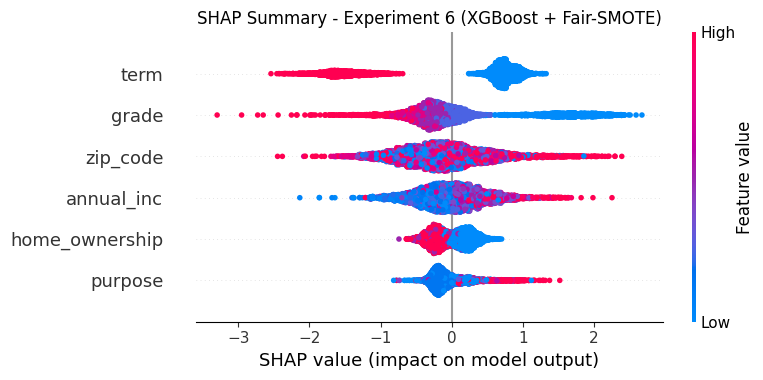

In [21]:
# Step 8: Run Validation
RESULTS_DIR = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation Results'
TESTDATA_PATH = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation dataset/TestData set.xlsx'

test_df = pd.read_excel(TESTDATA_PATH)
test_processed = preprocess_testdata(test_df)
results = validate_on_testdata(test_processed, clf)


In [22]:
# Step 9: Save Results
results_df = pd.DataFrame([results])
output_path = f'{RESULTS_DIR}/experiment6_validation_results_testdata.csv'
results_df.to_csv(output_path, index=False)
print(f'\nResults saved to: {output_path}')


Results saved to: /content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation Results/experiment6_validation_results_testdata.csv
